In [142]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

In [143]:
"""Synthetic data generation--- Final data will be availabe in X_train and Y_train"""
X_plus = [0,0,0,0]
X_minus = [0,0,0,0]
Y_plus = [0,0,0,0]
Y_minus = [0,0,0,0]
size = 150
for i in range(4):
    X_plus[i] = np.random.multivariate_normal(np.array([1,1]), np.array([[1,0],[0,1]]), size//2)   
    X_minus[i] = np.random.multivariate_normal(np.array([-1,1]), np.array([[1,0],[0,1]]), size//2)
    Y_plus[i] = np.full((size//2),1)
    Y_minus[i] = np.full((size//2),0) 

X_train = [0,0,0,0]
Y_train = [0,0,0,0]
for i in range(4):
    X_train[i] = np.concatenate((X_plus[i],X_minus[i]),axis = 0)
    Y_train[i] = np.concatenate((Y_plus[i],Y_minus[i]),axis =0)
    
#Finally four datasets are created 
#X_train[i],Y_train[i]---- i varies from 1 to 4
#These represent the data before distortion

In [144]:
print(X_train[0].shape)
print(Y_train[0].shape)

(150, 2)
(150,)


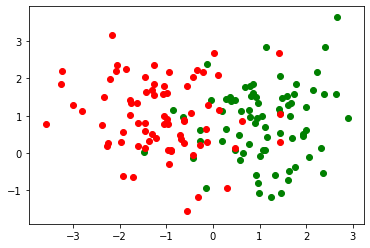

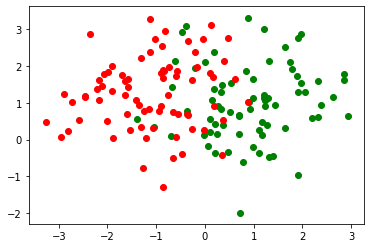

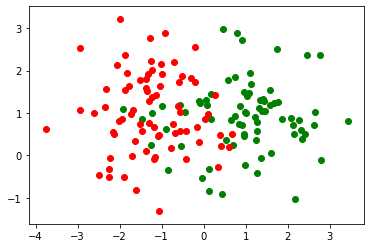

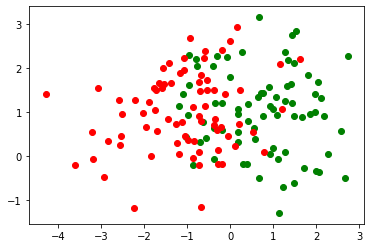

In [145]:
"""Plotting synthetic data generated"""
for i in range(4):
    X_plus_plot = X_plus[i].T
    X_minus_plot = X_minus[i].T
    plt.scatter(X_plus_plot[0],X_plus_plot[1],color = 'g')
    plt.scatter(X_minus_plot[0],X_minus_plot[1],color = 'r')
    plt.show()
    #X_plus_plot.shape
    


In [146]:
def sample_mean(A,length):
    """Function that returns sample mean of the given data"""
    return (np.sum(A,axis=0))/length

def sample_covariance(A, length, mu):
    """Function that returns sample covariance of the given data"""
    cov = np.array([[0,0],[0,0]])
    for x in A:
        y = np.array([x-mu])
        cov = cov + np.matmul(np.transpose(y),y)
        #print(cov)
    cov = cov/length
    return cov
def calc_posterior(x,mu_plus,cov_plus,mu_minus,cov_minus,prior):
    """ Function that calculates P(Y = +1|X) by using bayes formula"""
    plus_prob = stat.multivariate_normal.pdf(x,mu_plus,cov_plus)
    minus_prob = stat.multivariate_normal.pdf(x,mu_minus,cov_minus)
    val = (prior*plus_prob)/((prior*plus_prob)+((1-prior)*minus_prob))
    return val

In [147]:
def calculate_eta(X_train,Y_train):
    '''Function that finds P(1|X=x) for all training samples, so that later we can apply distortion later'''
    X_plus = [0,0,0,0]
    X_minus = [0,0,0,0]
    mu_hat_plus = [0,0,0,0]
    mu_hat_minus = [0,0,0,0]
    cov_hat_plus = [0,0,0,0]
    cov_hat_minus = [0,0,0,0]
    prior = [0,0,0,0]
    eta = [0,0,0,0]   # this list contains eta of all the data sets
    Y_pred = [0,0,0,0]
    for p in range(4):
        X_plus_temp = []
        X_minus_temp = []

        for i in range(int(X_train[p].shape[0])):
            if(Y_train[p][i] == 1):
                X_plus_temp.append(X_train[p][i])
            else:
                X_minus_temp.append(X_train[p][i])
        X_plus[p] = np.array(X_plus_temp)
        X_minus[p] = np.array(X_minus_temp)

        mu_hat_plus[p] = sample_mean(X_plus[p],X_plus[p].shape[0])
        mu_hat_minus[p] = sample_mean(X_minus[p],X_minus[p].shape[0])
        cov_hat_plus[p] = sample_covariance(X_plus[p],X_plus[p].shape[0],mu_hat_plus[p])
        cov_hat_minus[p] = sample_covariance(X_minus[p],X_minus[p].shape[0],mu_hat_minus[p] )

        len_plus = X_plus[p].shape[0]
        len_minus= X_minus[p].shape[0]
        prior[p] = len_plus /(len_plus + len_minus)
        eta_temp = []
        for i in range(X_train[p].shape[0]):
            eta_temp.append(calc_posterior(X_train[p][i],mu_hat_plus[p],cov_hat_plus[p],mu_hat_minus[p],cov_hat_minus[p],prior[p]))
        eta[p] = np.array(eta_temp)
        Y_pred_temp = []
        for i in range(X_train[p].shape[0]):
            Y_pred_temp.append(np.sign(eta[p][i]-0.5))
        Y_pred[p] = np.array(Y_pred_temp)
        #print(accuracy_score(Y_train[p],Y_pred[p]))
    return eta

In [148]:

def distort_eta(eta_original):
    eta_list = []
    eta_list.append(eta_original[0])       #correct labeller ---> no distortion caused
    eta_list.append(0.7*eta_original[1] + 0.1)  # linear distortion
    eta_list.append(0.5*stat.beta.cdf(eta_original[2],100,200) + 0.5*stat.beta.cdf(eta_original[2],200,100))   #aggressive labeller
    eta_list.append(0.5*stat.beta.cdf(eta_original[3],0.1,0.2) + 0.5*stat.beta.cdf(eta_original[3],0.2,0.1))  # distortion based on alpha = 0.5 and beta = 0.5
    return eta_list


def calculate_distorted_labels(eta_list):
    Y_distort = []
    for i in range(4):
        lis = []
        for p in eta_list[i]:
            res = (np.random.binomial(1,p,1) )
            if(res == 0): res = 0
            lis.append(res)
        lis = np.array(lis)
        Y_distort.append(lis)
    return Y_distort

In [149]:

eta_original = calculate_eta(X_train,Y_train)
eta_list = distort_eta(eta_original)
print(eta_original[0].size)
print(eta_list[0].size)
X_test_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
X_train_d = [0,0,0,0]
Y_train_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
Y_d = calculate_distorted_labels(eta_list)
trainsize = 100
testsize = 50
for i in range(4):
    X_train_d[i] = np.concatenate((X_train[i][:trainsize//2], X_train[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    X_test_d[i] = np.concatenate((X_train[i][trainsize//2:trainsize//2+testsize//2], X_train[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    Y_train_d[i] = np.concatenate((Y_d[i][:trainsize//2], Y_d[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    Y_test_d[i] = np.concatenate((Y_d[i][trainsize//2:trainsize//2+testsize//2], Y_d[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    print(X_train_d[i].shape, Y_train_d[i].shape,X_test_d[i].shape, Y_test_d[i].shape)
    
#Final distorted data is availabe as follows
#X_train_d[i],Y_train_d[i],X_test_d[i], Y_test_d[i]---- i varies from 1 to 4


150
150
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)


In [150]:
X_train_distort_plus = []
X_train_distort_minus = []
X_test_distort_plus = []
X_test_distort_minus = []
for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_train_d[i]:
        if(y == 1):
            lisplus.append(X_train_d[i][j])
        else:
            lisminus.append(X_train_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_train_distort_plus.append(lisplus)
    X_train_distort_minus.append(lisminus)
''''for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_test_d[i]:
        if(y == 1):
            lisplus.append(X_test_d[i][j])
        else:
            lisminus.append(X_test_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_test_distort_plus.append(lisplus)
    X_test_distort_minus.append(lisminus)'''
    


   


"'for i in range(4):\n    lisplus = []\n    lisminus = []\n    j = 0\n    for y in Y_test_d[i]:\n        if(y == 1):\n            lisplus.append(X_test_d[i][j])\n        else:\n            lisminus.append(X_test_d[i][j])\n        j = j + 1\n    lisplus = np.array(lisplus)\n    lisminus = np.array(lisminus)\n    X_test_distort_plus.append(lisplus)\n    X_test_distort_minus.append(lisminus)"

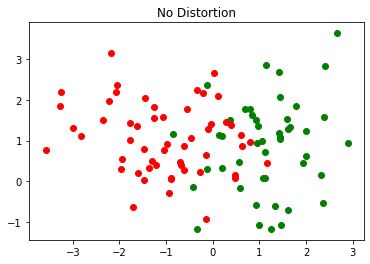

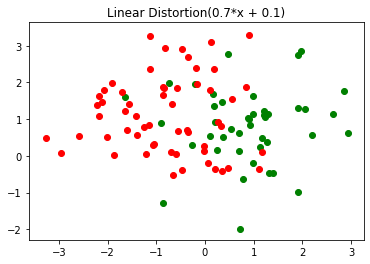

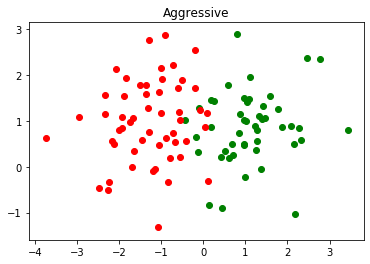

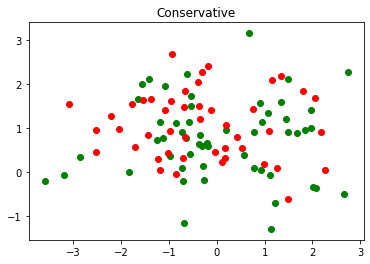

In [151]:
titles = ['No Distortion', 'Linear Distortion(0.7*x + 0.1)', 'Aggressive', 'Conservative']
for i in range(4):
    plt.title(titles[i])
    plt.scatter(X_train_distort_plus[i].T[0],X_train_distort_plus[i].T[1],color = 'g')
    plt.scatter(X_train_distort_minus[i].T[0],X_train_distort_minus[i].T[1],color = 'r')
    plt.show()
     #plt.scatter(X_test_distort_plus[i].T[0],X_test_distort_plus[i].T[1],color = 'g')
    #plt.scatter(X_test_distort_minus[i].T[0],X_test_distort_minus[i].T[1],color = 'r')
    #plt.show()

In [152]:
#Baseline-1
clf_list = []
accuracy_list = []
for i in range(4):
    Y_train_d[i] =Y_train_d[i].astype('int')
    Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])
    Y_pred = clf.predict(X_test_d[i])
    Y_pred = Y_pred.astype('int')
    #print(Y_pred)
    print(Y_pred.shape)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))
accuracy_list
#Y_test_distort[0].shape

(50,)
(50,)
(50,)
(50,)


[0.98, 0.86, 0.98, 0.6]

In [153]:
#converting samples into pairs and ranking them
Pairs_train = []
Ranks_train = []
for i in range(4):
    for j in range(X_train_d[i].shape[0]):
        for k in range(j+1,X_train_d[i].shape[0]):
            if(Y_train_d[i][j] - Y_train_d[i][k] == 1):
                Pairs_train.append([X_train_d[i][j][0],X_train_d[i][j][1],X_train_d[i][k][0],X_train_d[i][k][1]])
                Ranks_train.append(1)
            elif(Y_train_d[i][j] - Y_train_d[i][k] == -1):
                Pairs_train.append([X_train_d[i][j][0],X_train_d[i][j][1],X_train_d[i][k][0],X_train_d[i][k][1]])
                Ranks_train.append(0)
Pairs_train = np.array(Pairs_train)
print(Pairs_train.shape)
Ranks_train = np.array(Ranks_train)
print(Ranks_train.shape)

(9910, 4)
(9910,)


In [154]:
#Classifying the 4-d data with labels as ranks
Ranks_train = Ranks_train.astype('int')
final_clf = LogisticRegression(solver='lbfgs').fit(Pairs_train, Ranks_train)
final_clf.predict(np.array([[1,2,3,4]]))

array([0])

In [155]:
#Converting the ranker obtained into classifier
accuracy2_list = []
Y_pred = []
for i in range(4):
    temp_pred = []
    for z in X_test_d[i]:
        a = 0          #indicates that z is more risky than 'a' people who were already detected as cancer
        b = 0          #indicaates that x is more risky than 'b' people who were detected safe
        prediction = 0
        for x1 in X_train_distort_plus[i]:
            if(int(final_clf.predict(np.array([[z[0],z[1],x1[0],x1[1]]]))) == 1):
                a = a + 1
        for x2 in X_train_distort_minus[i]:
            if(int(final_clf.predict(np.array([[z[0],z[1],x2[0],x2[1]]]))) == 1):
                b = b + 1
        if(a >= len(X_train_distort_plus[i])/2):
            prediction = 1
        elif(b <= len(X_train_distort_minus[i])/2):
            prediction = 0
        elif((a+b)/(len(X_train_distort_plus[i]) + len(X_train_distort_minus[i])) < 0.5):
            prediction = 0
        else:
            prediction = 1
        temp_pred.append(prediction)
    temp_pred = np.array(temp_pred)
    Y_pred.append(temp_pred)
    temp_pred = temp_pred.astype('int')
    accuracy2_list.append(accuracy_score(Y_test_d[i],temp_pred))
            
accuracy2_list      

[0.96, 0.84, 1.0, 0.58]

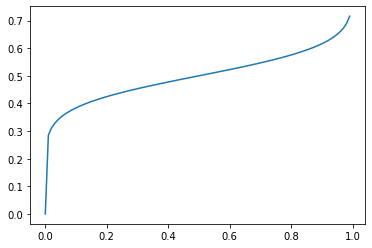

In [156]:
x = np.arange(0,1,0.01)
y = stat.beta.cdf(x,0.1,0.5)
alpha = np.arange(1,5,1)
beta = np.arange(1,5,1)
#for a in alpha:
#for b in beta:
y = 0.5*stat.beta.cdf(x,0.1,0.2) + 0.5* stat.beta.cdf(x,0.2,0.1)
plt.plot(x,y)
plt.show()
#If we are put    

In [157]:
Z_train = [0,0,0,0]
Z_train_label = [0,0,0,0]
for i in range(4):
    temp = []
    temp_label = []
    for j in range(len(X_train_d[i])):
        for k in range(j+1,len(X_train_d[i])):
            if(Y_train_d[i][j] != Y_train_d[i][k]):
                temp.append(X_train_d[i][j]-X_train_d[i][k] )
                temp_label.append((Y_train_d[i][j]- Y_train_d[i][k] + 1)//2)
    Z_train[i] = np.array(temp)
    Z_train_label[i] = np.array(temp_label)
                


In [158]:
Z_train[1].shape

(2451, 2)

In [159]:
sr_clf_list = []
sr_accuracy_list = []
for i in range(4):
    Z_train_label[i] =Z_train_label[i].astype('int')
    Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(Z_train[i], Z_train_label[i])
    sr_clf_list.append(clf)

In [160]:
sr_probab = [0,0,0,0]
iso_reg = [0,0,0,0]
for i in range(4):
    sr_probab[i] = (sr_clf_list[i].predict_proba(X_train_d[i]))[:,1]
    iso_reg[i] = IsotonicRegression().fit(sr_probab[i],Y_train_d[i])
    

In [161]:
Y_pred_sr = [0,0,0,0]
sr_accuracy_list = [0,0,0,0]
for i in range(4):
    temp=  iso_reg[i].predict((sr_clf_list[i].predict_proba(X_test_d[i]))[:,1])
    temp_pred = []
    for j in range(len(temp)):
        if(temp[j] >=0.5):
            temp_pred.append(1)
        else:
            temp_pred.append(0)
    Y_pred_sr [i] = np.array(temp_pred) 
    sr_accuracy_list[i] = accuracy_score(Y_test_d[i],Y_pred_sr[i])
sr_accuracy_list

[0.92, 0.84, 0.98, 0.6]